In [1]:
# IGNORE THIS CELL WHICH CUSTOMIZES LAYOUT AND STYLING OF THE NOTEBOOK !
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings = lambda *a, **kw: None

# Exercise 3.4 Colorbars
prepared by M.Hauser

We got to know colorbars in Exercises 1.3 and 1.5. However, there are some quirks when adding colorbars to map plots. 
We have already seen that colorbars can be too large for map-plots, which does not happen for 'normal' plots (with exceptions). We will discuss how to overcome this problem in this exercise.

> This exercise only applies to map plots (or plots where the aspect ratio needs to be equal.)



## Import libraries

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline

In [3]:
import mplotutils as mpu

## Load data: CMIP 5, relative precipitation change

We use a netCDF with historical, and projected climatlological precipitation, as well as the relative change between them, from all CMIP5 models for RCP8.5 (Taylor et al., 2012).

The data was prepared in [another notebook](../data/prepare_CMIP5_map.ipynb).

In [4]:
fN = '../data/cmip5_delta_pr_rcp85_map.nc'

# load data, omitting some unecessary variables
pr = xr.open_dataset(fN, drop_variables=['agree_sign', 'pval'])

pr

<xarray.Dataset>
Dimensions:  (lon: 144, lat: 72)
Coordinates:
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Data variables:
    pr_rel   (lat, lon) float64 ...
    proj     (lat, lon) float64 ...
    hist     (lat, lon) float64 ...
Attributes:
    data:                CMIP5 precipitation (pr)
    time_periods:        hist: 1986-2005; proj: 2081-2100
    pr_delta:            (proj - hist) / hist * 100
    source:              https://data.iac.ethz.ch/atmos/
    reference:           Taylor et al., 2012
    scenario:            rcp8.5
    interpolation_grid:  2.5 x 2.5 degrees bilinear interpolation

## Reminder

As noted before, colorbars are usually created as

    plt.colorbar(h, ax=ax)
    
### Exercise

We plot the relative change in precipitation between a historical and future time period, calculated from CMIP5 data.

 * add a colorbar
 * use the `label` keyword argument to indicate that we show a `'Rel. change [%]'`

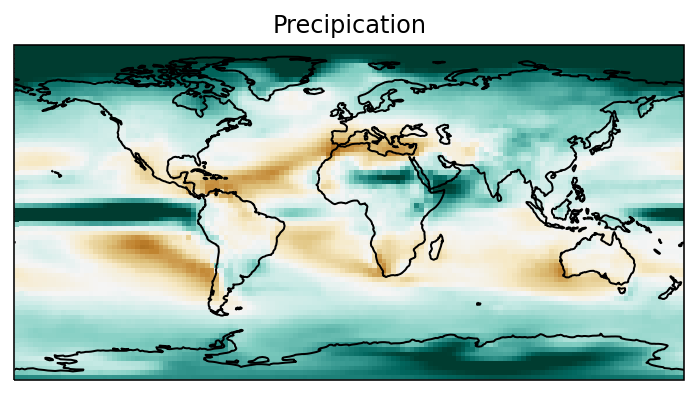

In [5]:
# create normal plot
f, axes = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))

#f.set_size_inches(w=10 / 2.54, h=16 / 2.54)

ax = axes
h = ax.pcolormesh(pr.lon, pr.lat, pr.pr_rel, shading='nearest', transform=ccrs.PlateCarree(), 
                  cmap='BrBG', vmin=-50, vmax=50)


ax.set_title('Precipication')
ax.coastlines()
ax.set_global()
      
# ==========================
# add colorbar



### Solution

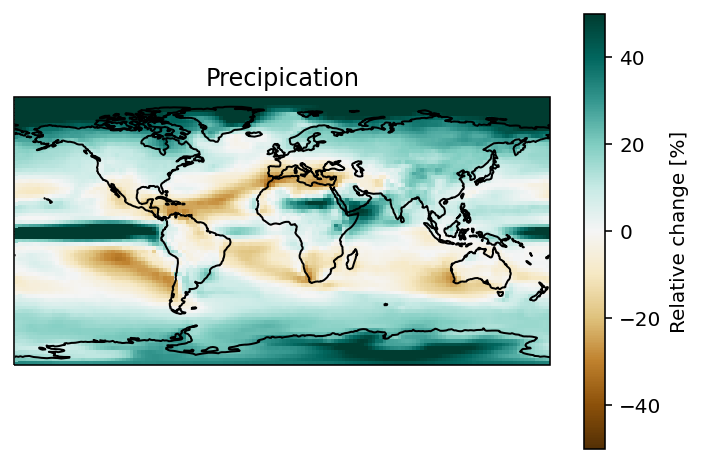

In [6]:
# create normal plot
f, axes = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))

#f.set_size_inches(w=10 / 2.54, h=16 / 2.54)

ax = axes
h = ax.pcolormesh(pr.lon, pr.lat, pr.pr_rel, shading='nearest', transform=ccrs.PlateCarree(), 
                  cmap='BrBG', vmin=-50, vmax=50)


ax.set_title('Precipication')
ax.coastlines()
ax.set_global()
      
# =======
# add colorbar
cbar = plt.colorbar(h, ax=ax, label='Relative change [%]')

## The 'problem'

The colorbar is larger than the axes! Depending on the the map and the extent of the map this can even be worse. Lets illustrate this with some artificial data.

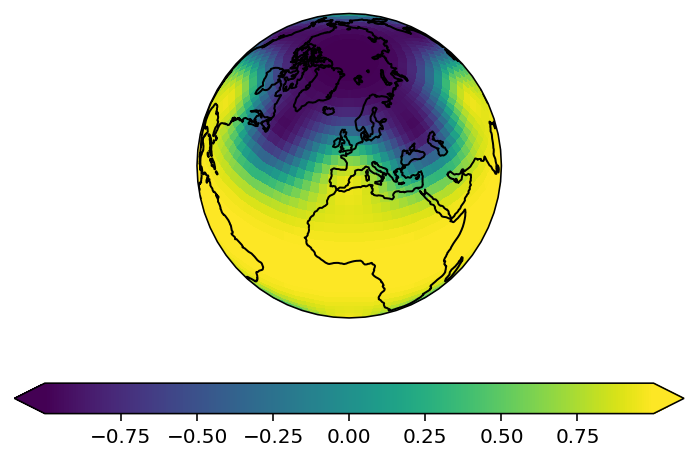

In [7]:
# create sample data
lon, lat, data = mpu.sample_data_map(90, 48)
# ====

ax = plt.axes(projection=ccrs.Orthographic(central_latitude=45))

ax.coastlines()
h = ax.pcolormesh(lon, lat, data, shading='nearest', transform=ccrs.PlateCarree())

plt.colorbar(h, extend='both', orientation='horizontal')

ax.set_global()

#### Why is this a problem for map plots but not for others?

We have seen examples where the colorbar just worked fine with axes. The issue is that the aspect ratio of a map plot has to be equal, else the map would be distorted. Matplotlib then 'shrinks' the axes, but does not shrink the area of the figure. The colorbar is correct when we set the aspect to 'auto', but then of course the map distorted...

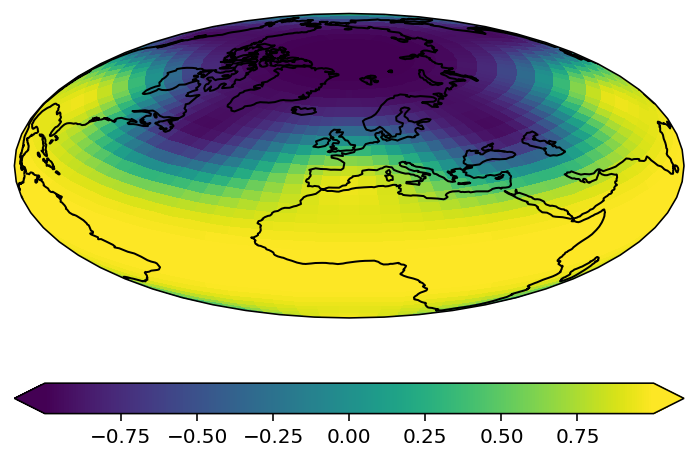

In [8]:
# create sample data
lon, lat, data = mpu.sample_data_map(90, 48)
# ====

ax = plt.axes(projection=ccrs.Orthographic(central_latitude=45))

ax.coastlines()
h = ax.pcolormesh(lon, lat, data, shading='nearest', transform=ccrs.PlateCarree())


plt.colorbar(h, extend='both', orientation='horizontal')

ax.set_aspect('auto')

ax.set_global()

# The 'Solution'

I developed a function that creates colorbars of the correct size - `mpu.colorbar`.

The solution is inspired by this [stackoverflow answer](https://stackoverflow.com/a/30077745). The trick is to read out the coordinates of the cartopy axes and adjust the position of the colorbar accordingly. Because the position of the cartopy axes can change, we have to redo this everytime the plot get's drawn.

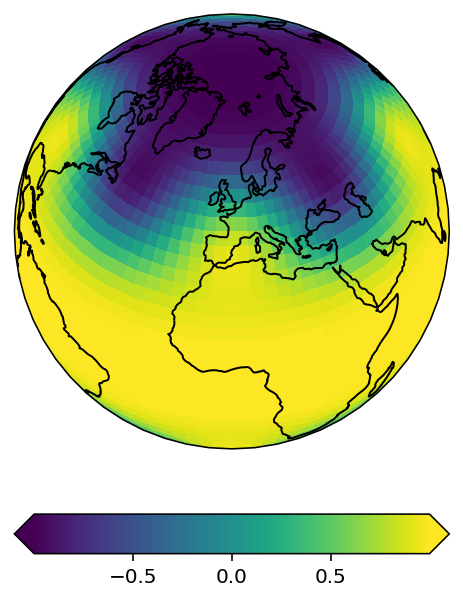

In [9]:
# create sample data
lon, lat, data = mpu.sample_data_map(90, 48)
# ====

ax = plt.axes(projection=ccrs.Orthographic(central_latitude=45))

ax.coastlines()
h = ax.pcolormesh(lon, lat, data, shading='nearest', transform=ccrs.PlateCarree())

ax.set_global()

# =======
# add colorbar
mpu.colorbar(h, ax, extend='both', orientation='horizontal', aspect=10)

plt.draw()

Have a look at the help:

In [10]:
mpu.colorbar?

Signature:
mpu.colorbar(
    mappable,
    ax1,
    ax2=None,
    orientation='vertical',
    aspect=None,
    size=None,
    pad=None,
    shift='symmetric',
    shrink=None,
    **kwargs,
)
Docstring:
automatically resize colorbars on draw

See below for Example

Parameters
----------
mappable : handle
    The return value of 'ax.contourf', 'ax.pcolormesh' etc to 
    which the colorbar applies.
ax1 : Axes
    Axes to adjust the colorbar to.
ax2 : Axes, optional 
    If the colorbar should span more than one Axes. Default: None.
orientation : 'vertical' | 'horizontal', optional
    Orientation of the colorbar. Default: 'vertical'.
aspect : float, optional
    The ratio of long to short dimensions of the colorbar. Default 20.
    Mutually exclusive with 'size'.
size : float
    Width of the colorbar as fraction of the axes width (vertical) or
    height (horizontal). Mutually exclusive with 'aspect'. Default: None.
pad : float
    Distance of the colorbar to the axes in Figure coordin

### Exercise

Let's go back to the relative precipitation change

 * add a horizontal colorbar
 * add the units (`'[mm]'`) below the colorbar (use `cbar.set_label`)

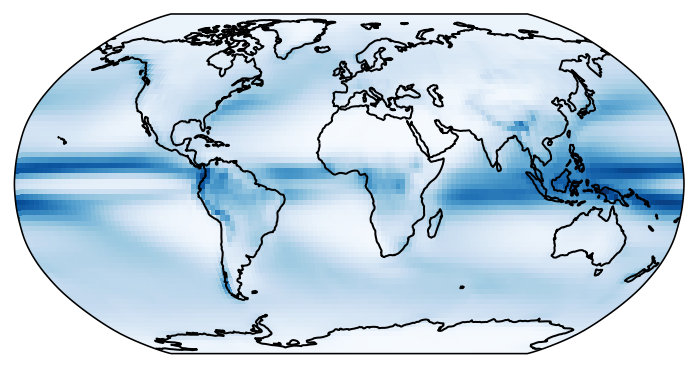

In [11]:
# create normal plot
f = plt.figure()

ax = plt.axes(projection=ccrs.Robinson())

ax.coastlines()

h = ax.pcolormesh(pr.lon, pr.lat, pr.hist, shading='nearest', transform=ccrs.PlateCarree(), 
                  cmap='Blues', vmin=0, vmax=4000)

# =======
# add colorbar here
# cbar = mpu.colorbar(...)

# add the units


# this is required
ax.set_global()

# tell mpl to draw
plt.draw()

### Solution

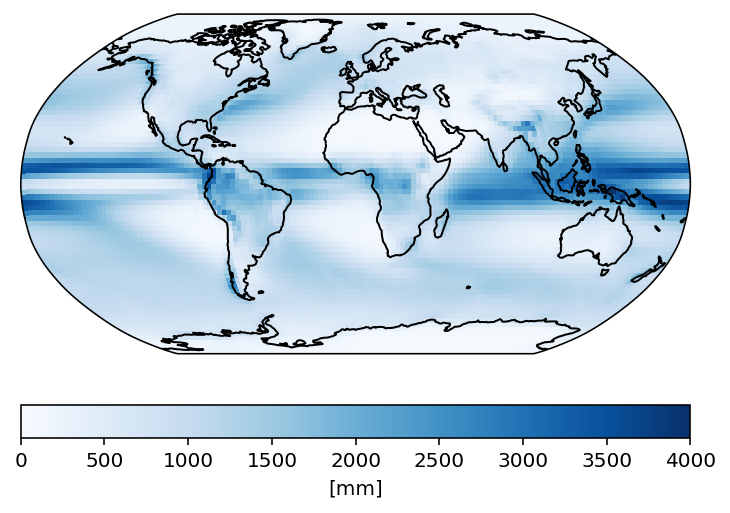

In [12]:
# create normal plot
f = plt.figure()

ax = plt.axes(projection=ccrs.Robinson())

ax.coastlines()


h = ax.pcolormesh(pr.lon, pr.lat, pr.hist, shading='nearest', transform=ccrs.PlateCarree(), 
                  cmap='Blues', vmin=0, vmax=4000)

# add colorbar here

# this is required
ax.set_global()

cbar = mpu.colorbar(h, ax, orientation='horizontal')

# add the units
cbar.set_label('[mm]')

# tell mpl to draw
plt.draw()

## More than one axes

You can add a colorbar that spans more than one axes. To achieve that you need to pass the left- and rightmost axes to `mpu.colorbar` (or the bottom- and topmost).

````ipython
cbar = mpu.colorbar(h, axes[0], axes[1])
```


### Exercise

Here we plot the precipitation climatology of the historical and future period.

 * add a `'horizontal'` colorbar that spans both axes in the plot showing historical and projected rainfall amounts
 * the colorbar is a bit large, play with the `aspect` keyword to find a better size.
 * swap `axes[0]` and `axes[1]` in `mpu.colorbar` - is it still correct?
 * save the figure as a pdf
 * is the colorbar at the right position in the saved figure?


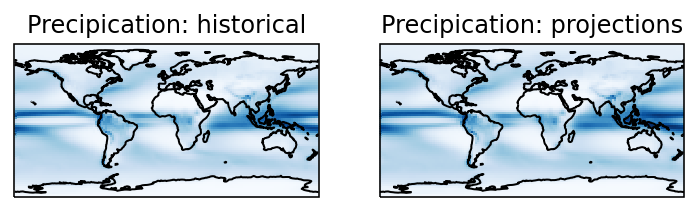

In [13]:
# create normal plot
f, axes = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.PlateCarree()))

ax = axes[0]
h = ax.pcolormesh(pr.lon, pr.lat, pr.hist, shading='nearest', transform=ccrs.PlateCarree(), 
                  cmap='Blues', vmin=0, vmax=4000, rasterized=True)

ax.set_title('Precipication: historical')

ax = axes[1]
h = ax.pcolormesh(pr.lon, pr.lat, pr.proj, shading='nearest', transform=ccrs.PlateCarree(), 
                  cmap='Blues', vmin=0, vmax=4000, rasterized=True)

ax.set_title('Precipication: projections')


for ax in axes:
    ax.coastlines()
    ax.set_global()


# =======
# create the colorbar
# cbar = mpu.colorbar(...)

# save figure


### Solution


/Users/tarunchadha/opt/miniconda3/envs/pyvis/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1117: RuntimeWarning: Glyph 0 missing from current font.
  width = font.load_char(
/Users/tarunchadha/opt/miniconda3/envs/pyvis/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1117: RuntimeWarning: Glyph 1 missing from current font.
  width = font.load_char(
/Users/tarunchadha/opt/miniconda3/envs/pyvis/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1117: RuntimeWarning: Glyph 2 missing from current font.
  width = font.load_char(
/Users/tarunchadha/opt/miniconda3/envs/pyvis/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1117: RuntimeWarning: Glyph 3 missing from current font.
  width = font.load_char(
/Users/tarunchadha/opt/miniconda3/envs/pyvis/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1117: RuntimeWarning: Glyph 4 missing from current font.
  width = font.load_char(
/Users/tarunchadha/opt/miniconda3/envs/pyvis/

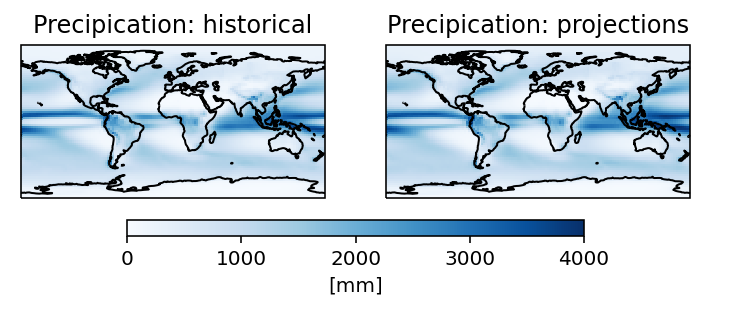

In [14]:
# create normal plot
f, axes = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.PlateCarree()))

ax = axes[0]
h = ax.pcolormesh(pr.lon, pr.lat, pr.hist, shading='nearest', transform=ccrs.PlateCarree(), 
                  cmap='Blues', vmin=0, vmax=4000, rasterized=True)

ax.set_title('Precipication: historical')

ax = axes[1]
h = ax.pcolormesh(pr.lon, pr.lat, pr.proj, shading='nearest', transform=ccrs.PlateCarree(), 
                  cmap='Blues', vmin=0, vmax=4000, rasterized=True)

ax.set_title('Precipication: projections')


for ax in axes:
    ax.coastlines()
    ax.set_global()


# create the colorbar
cbar = mpu.colorbar(h, axes[0], axes[1], orientation='horizontal', aspect=30)
cbar.set_label('[mm]')

# save figure
plt.savefig('pr_hist_proj.pdf')

## Some more stuff you can do

* span multiple axes
* more than one colorbar per axes



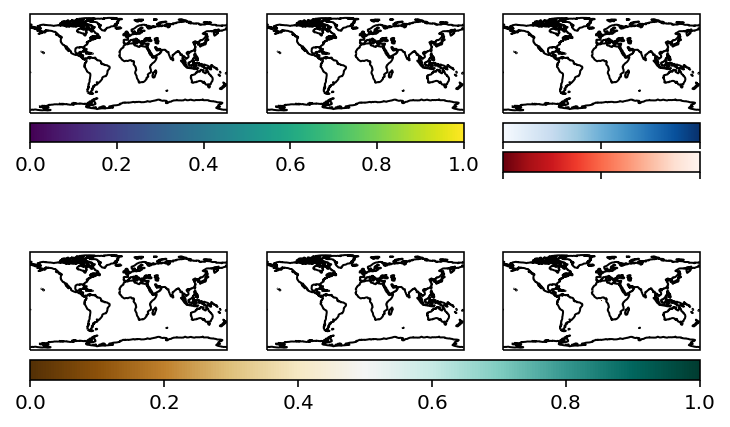

In [15]:
f, axes = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.PlateCarree()))

axes = axes.flatten()

for ax in axes:
    ax.coastlines() 
    ax.set_global()

h0 = ax.pcolormesh([[0, 1]])
h1 = ax.pcolormesh([[0, 1]])

h2_1 = ax.pcolormesh([[0, 1]], cmap='Blues')
h2_2 = ax.pcolormesh([[0, 1]], cmap='Reds_r')


h3 = ax.pcolormesh([[0, 1]], cmap='BrBG')

# ====
# single colorbar
cbar = mpu.colorbar(h1, axes[0], axes[1], size=0.2, pad=0.1, orientation='horizontal')

# ====
# two colorbars
cbar = mpu.colorbar(h2_1, axes[2], size=0.2, pad=0.1, orientation='horizontal')
cbar.ax.set_xticklabels([])

cbar = mpu.colorbar(h2_2, axes[2], size=0.2, pad=0.4, orientation='horizontal')
cbar.ax.set_xticklabels([])

# ====
# colorbar for three axes
cbar = mpu.colorbar(h3, axes[-1], axes[3], size=0.2, pad=0.1, orientation='horizontal')

# ====

plt.draw()



## shrink and shift

you can use the `shrink` and `shift` keywords to adjust the position of the colorbar. `shrink` and `shift` are in fraction of the total width/ height of the colorbar.


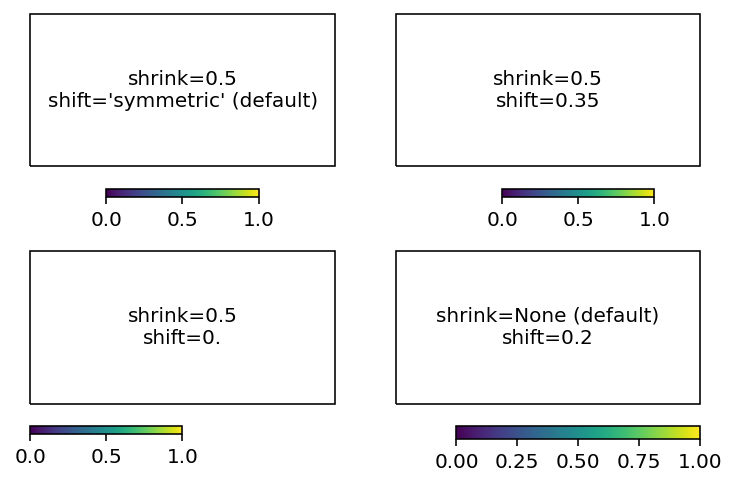

In [16]:
f, axes = plt.subplots(2, 2, subplot_kw=dict(projection=ccrs.PlateCarree()))

axes = axes.flatten()

for ax in axes:
    ax.set_global()

h = ax.pcolormesh([[0, 1]])

ax = axes[0]
mpu.colorbar(h, ax, orientation='horizontal', shrink=0.5)
ax.text(0.5, 0.5, "shrink=0.5\nshift='symmetric' (default)", ha='center', va='center')

ax = axes[1]
mpu.colorbar(h, ax, orientation='horizontal', shrink=0.5, shift=0.35)
ax.text(0.5, 0.5, 'shrink=0.5\nshift=0.35', ha='center', va='center')

ax = axes[2]
mpu.colorbar(h, ax, orientation='horizontal', shrink=0.5, shift=0)
ax.text(0.5, 0.5, 'shrink=0.5\nshift=0.', ha='center', va='center')

ax = axes[3]
mpu.colorbar(h, ax, orientation='horizontal', shrink=None, shift=0.2)
ax.text(0.5, 0.5, 'shrink=None (default)\nshift=0.2', ha='center', va='center')

plt.draw()

### Exercise

Now we plot the historical and future precipitation climatology, as well as its relative change.

 * add one colorbar for the climatologies and one for the relative change
 * add the units with `cbar.ax.set_xlabel`
 * use `shrink` and `shift` to make room for the xlabel
 > you may have to use different values for `shrink` and `shift` for the two colorbars
 * set `extend='both'` and `extendfrac=0.1` for the second colorbar
 > Per default `mpu.colorbar` sets the width of the colorbar with its aspect ratio. As the two are not of the same height, it is recommended to use `size` instead. 

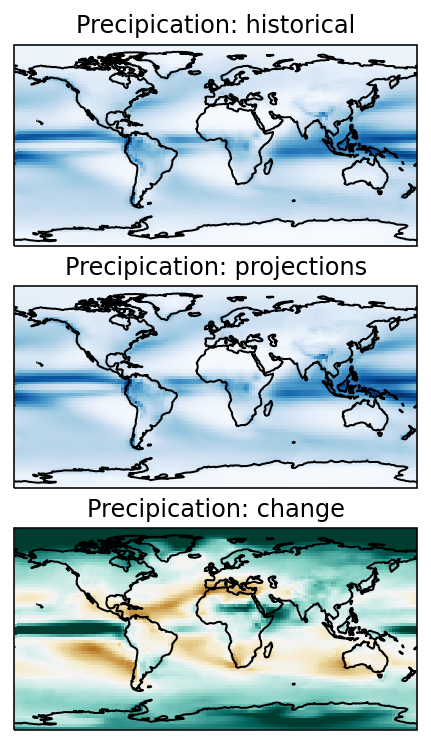

In [17]:
# create normal plot
f, axes = plt.subplots(3, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))

f.set_size_inches(w=10 / 2.54, h=16 / 2.54)


ax = axes[0]
h0 = ax.pcolormesh(pr.lon, pr.lat, pr.hist, shading='nearest', transform=ccrs.PlateCarree(), 
                  cmap='Blues', vmin=0, vmax=4000)


ax = axes[1]
h1 = ax.pcolormesh(pr.lon, pr.lat, pr.proj, shading='nearest', transform=ccrs.PlateCarree(), 
                  cmap='Blues', vmin=0, vmax=4000)


ax = axes[2]
h2 = ax.pcolormesh(pr.lon, pr.lat, pr.pr_rel, shading='nearest', transform=ccrs.PlateCarree(), 
                  cmap='BrBG', vmin=-50, vmax=50)



axes[0].set_title('Precipication: historical')
axes[1].set_title('Precipication: projections')
axes[2].set_title('Precipication: change')

for ax in axes:
    ax.coastlines()
    ax.set_global()


# first colorbar


# second colorbar


plt.draw()

### Solution

As shift is relative to the height of the colorbar, I use `shift=0.1` for the upper colorbar and `shift=0.2` for the lower colorbar. This creates approximately the same absolute shift.

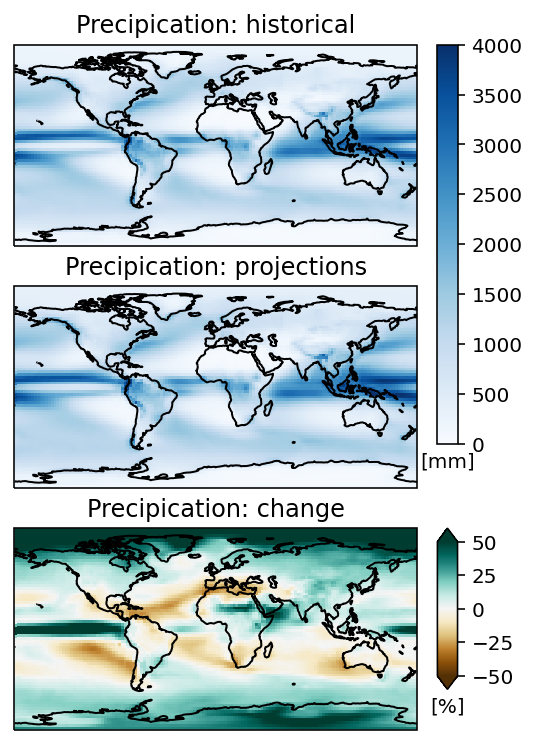

In [18]:
# create normal plot
f, axes = plt.subplots(3, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))

f.set_size_inches(w=10 / 2.54, h=16 / 2.54)


ax = axes[0]
h0 = ax.pcolormesh(pr.lon, pr.lat, pr.hist, shading='nearest', transform=ccrs.PlateCarree(), 
                  cmap='Blues', vmin=0, vmax=4000)


ax = axes[1]
h1 = ax.pcolormesh(pr.lon, pr.lat, pr.proj, shading='nearest', transform=ccrs.PlateCarree(), 
                  cmap='Blues', vmin=0, vmax=4000)


ax = axes[2]
h2 = ax.pcolormesh(pr.lon, pr.lat, pr.pr_rel, shading='nearest', transform=ccrs.PlateCarree(), 
                   cmap='BrBG', vmin=-50, vmax=50)



axes[0].set_title('Precipication: historical')
axes[1].set_title('Precipication: projections')
axes[2].set_title('Precipication: change')

for ax in axes:
    ax.coastlines()
    ax.set_global()


# first colorbar
cbar = mpu.colorbar(h1, axes[0], axes[1], shift=0.1, size=0.05)
cbar.ax.set_xlabel('[mm]')



# second colorbar
cbar = mpu.colorbar(h2, axes[2], shift=0.2, size=0.05, extendfrac=0.1, extend='both')
cbar.ax.set_xlabel('[%]')

plt.draw()

# Bonus: Alternative Solution

There is a second way to create a colorbar that has the right size - using `axes_grid1`.

"[axes_grid1](https://matplotlib.org/2.0.2/mpl_toolkits/axes_grid/users/overview.html) is a collection of helper classes to ease displaying (multiple) images with matplotlib. In matplotlib, the axes location (and size) is specified in the normalized figure coordinates, which may not be ideal for displaying images that needs to have a given aspect ratio."

 > However, it is not part of the core matplotlib functionality, and not it's best-documented part

From the axes_grid1 toolkit we need `make_axes_locatable`:

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

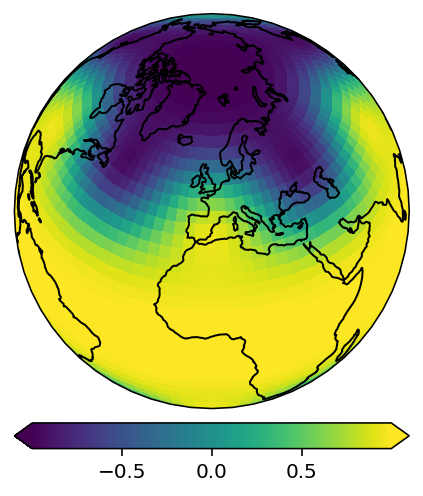

In [21]:
# create sample data
lon, lat, data = mpu.sample_data_map(90, 48)
# ====

ax = plt.axes(projection=ccrs.Orthographic(central_latitude=45))

ax.coastlines()
h = ax.pcolormesh(lon, lat, data, shading='nearest', transform=ccrs.PlateCarree())

ax.set_global()

# =======
# add colorbar

# create axes that has the right size
divider = make_axes_locatable(ax)
cbax = divider.append_axes('bottom', size="6.5%", pad=0.1, axes_class=plt.Axes)

# create colorbar in this axes
cbar = plt.colorbar(h, cax=cbax, orientation='horizontal', extend='both')


> you need to pass `axes_class=plt.Axes` to `append_axes`, else it fails miserably (because it tries to create a new axes with a projection). 


### Exercise

 * add a vertical colorbar to the historical precipitation plot (over Europe)

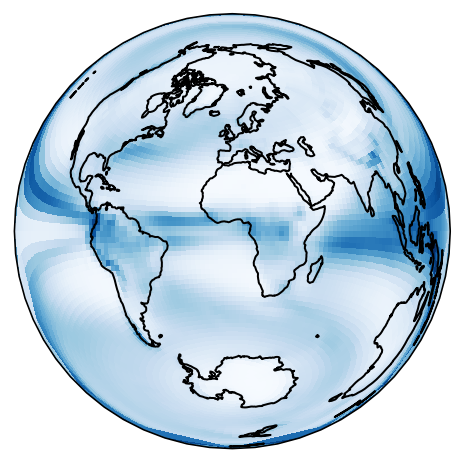

In [22]:
# create normal plot
f = plt.figure()

ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea())

ax.coastlines()


h = ax.pcolormesh(pr.lon, pr.lat, pr.hist, shading='nearest', transform=ccrs.PlateCarree(), 
                  cmap='Blues', vmin=0, vmax=4000)


# add colorbar here

If this does not look entirely correct - you may me right - you have to add `ax.set_global()` or `ax.set_extent([...], ccrs.PlateCarree())`!

### Solution

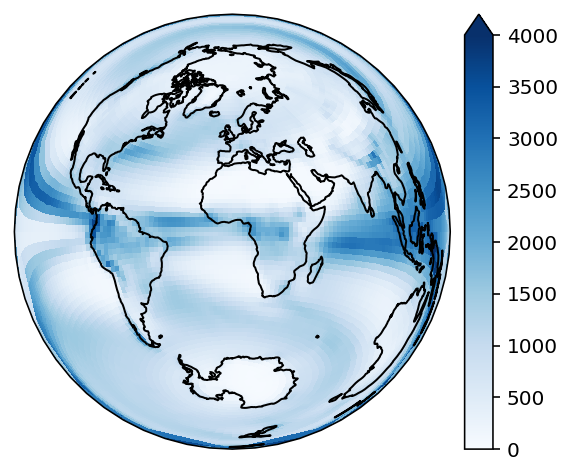

In [23]:
# create normal plot
f = plt.figure()

ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea())

ax.coastlines()



h = ax.pcolormesh(pr.lon, pr.lat, pr.hist, shading='nearest', transform=ccrs.PlateCarree(), 
                  cmap='Blues', vmin=0, vmax=4000)

# add colorbar here

# this is required
ax.set_global()

# create axes that has the right size
divider = make_axes_locatable(ax)
cbax = divider.append_axes('right', size="6.5%", pad=0.1, axes_class=plt.Axes)

# create colorbar in this axes
cbar = plt.colorbar(h, cax=cbax, orientation='vertical', extend='max')

### Limitations

The solution with `axes_grid1` is reasonably that works well, however, it has (afaik) two limitations:
 * the colorbar cannot span more than one axes
 * you cannot shrink the colorbar, e.g. to make room for a label below